# Initiate

In [1]:
import numpy as np
from math import comb
import myplots
import matplotlib.pylab as plt
from glob import glob
from scipy.optimize import least_squares

mp = myplots.Figpref()
plt.rcParams['font.size'] = '15'

def get_Nb(p,D,fault):
    if fault:
        Nb = comb(p+D-1,D-1)
    else:
        Nb = comb(p+D,D)
    return Nb

def get_dof(D,fault,poisson):
    if poisson: 
        dof = 1
    else:
        if fault: dof = D-1
        else: dof = D
    return dof

def get_Ndof(Ne,p,D=2,fault=False,poisson=True):
    dof = get_dof(D,fault,poisson)
    Nb = get_Nb(p,D,fault)
    Ndof = Ne * Nb * dof
    return Ndof

def extract_Ne(Ndof,p,D=2,fault=False,poisson=True):
    dof = get_dof(D,fault,poisson)
    Nb = get_Nb(p,D,fault)
    Ne =  Ndof / (Nb * dof)
    return Ne

def plot_scatter(ax,ndof,t,tit,col='k',noylab=False):
    ax.scatter(ndof,t,s=100,fc=col,marker='s')
    ax.set_xlabel('$N_{DOF}$',fontsize=17)
    if not noylab: ax.set_ylabel('Solve Time [s]',fontsize=17)
    ax.set_title(tit,fontsize=21,fontweight='bold')
    ax.grid(True,alpha=0.5)

def rhs_log(x,ndof):
    m,logA = x[0],x[1]
    return logA + m * np.log(ndof)

def cost_log(x,ndof,t):
    C = x[2]
    return np.log(t-C)-rhs_log(x,ndof)

def fit_curve_log(Ndof,T,init_coeff,print_on=True):
    optimize = least_squares(cost_log,init_coeff,args=(Ndof,T))
    coeff = optimize.x
    if print_on: print('m = %1.2f, A = %1.2e, C = %1.2f with cost = %1.2e'%(coeff[0],np.exp(coeff[1]),coeff[2],optimize.cost))
    return coeff

def rhs(x,ndof):
    m,A,C = x[0],x[1],x[1]
    return A*(ndof**m) + C

def cost(x,ndof,t):
    return t-rhs(x,ndof)

def fit_curve(Ndof,T,init_coeff,print_on=True):
    optimize = least_squares(cost,init_coeff,args=(Ndof,T))
    coeff = optimize.x
    if print_on: print('m = %1.2f, A = %1.2e, C = %1.2f with cost = %1.2e'%(coeff[0],np.exp(coeff[1]),coeff[2],optimize.cost))
    return coeff

def read_Ndof_T0(prefix,print_on=True,p=6,D=2,fault=False,poisson=True):
    # Read N_DOF & solve time T0 from log file
    log_files = glob(prefix)
    T0_KSPSolve = np.zeros(len(log_files))
    T0_PCSetUp = np.zeros(len(log_files))
    Ndof_volume = np.zeros(len(log_files))
    Ndof_fault = np.zeros(len(log_files))
    found = [0,0]
    for i,lf in enumerate(np.sort(log_files)):
        with open(lf, 'r') as f:
            for line in f:
                if 'DOFs (domain)' in line:
                    Ndof_volume[i] = int(line.split(': ')[-1])
                if 'DOFs (fault)' in line:
                    Ndof_fault[i] = int(line.split(': ')[-1])
                if 'PCSetUp' in line:
                    pc_count = int(line.split()[1])
                    pc_time = float(line.split()[3])
                    if pc_count != 1: print('PCSetUp performed more than once - review %s'%(lf))
                    T0_PCSetUp[i] = pc_time
                    found[0] = 1
                if 'KSPSolve' in line:
                    ksp_count = int(line.split()[1])
                    ksp_time = float(line.split()[3])
                    T0_KSPSolve[i] = ksp_time/ksp_count
                    found[1] = 1
                if found[0] == 1 and found[1] == 1:
                    found = [0,0]
                    break
    if print_on: print('Ndof:',Ndof_volume)
    if print_on: print('Ne:',extract_Ne(Ndof_volume,p,D,fault,poisson))
    return Ndof_volume,Ndof_fault,T0_PCSetUp,T0_KSPSolve

# Exercise 1: estimate the exponent m with MUMPS - h-refinement

In [ ]:
save_on = 1

Ndof_volume,_,T0_PCSetUp,T0_KSPSolve = read_Ndof_T0('scale_test/messages_refine*.log',print_on=True,p=6,D=2,fault=False,poisson=True)
coeff_PC = fit_curve_log(Ndof_volume,T0_PCSetUp,[1,1,0])
coeff_KSP = fit_curve_log(Ndof_volume,T0_KSPSolve,[1,1,0])
ndofs = np.linspace(1,np.exp(16.3),500)

fig,ax=plt.subplots(ncols=2,figsize=(15,6))
plot_scatter(ax[0],Ndof_volume,T0_PCSetUp,'PCSetUp')
ax[0].plot(ndofs,np.exp(rhs_log(coeff_PC,ndofs))+coeff_PC[2],color=mp.myburgundy,lw=2)
yl = ax[0].get_ylim()
ax[0].text(Ndof_volume[0],yl[1]-(yl[1]-yl[0])*0.1,'m = %1.2f'%(coeff_PC[0]),fontsize=18,fontweight='bold',color=mp.myburgundy,ha='left',va='top')
ax[0].text(Ndof_volume[0],yl[1]-(yl[1]-yl[0])*0.175,'A = %1.2e; C = %1.2e'%(np.exp(coeff_PC[1]),coeff_PC[2]),fontsize=15,color='0.3',ha='left',va='top')
ax[0].set_ylim(yl)

plot_scatter(ax[1],Ndof_volume,T0_KSPSolve,'KSPSolve',noylab=True)
yl = ax[1].get_ylim()
ax[1].plot(ndofs,np.exp(rhs_log(coeff_KSP,ndofs))+coeff_KSP[2],color=mp.myburgundy,lw=2)
ax[1].text(Ndof_volume[0],yl[1]-(yl[1]-yl[0])*0.1,'m = %1.2f'%(coeff_KSP[0]),fontsize=18,fontweight='bold',color=mp.myburgundy,ha='left',va='top')
ax[1].text(Ndof_volume[0],yl[1]-(yl[1]-yl[0])*0.175,'A = %1.2e; C = %1.2e'%(np.exp(coeff_KSP[1]),coeff_KSP[2]),fontsize=15,color='0.3',ha='left',va='top')
ax[1].set_ylim(yl)
plt.tight_layout()
if save_on: plt.savefig('est_rank1_exponent_h_refine.png',dpi=300)
plt.show()

# Exercise 2: estimate the exponent m with MUMPS - p-refinement

In [ ]:
save_on = 1

Ndof_volume,_,T0_PCSetUp,T0_KSPSolve = read_Ndof_T0('scale_test/messages_p*.log',print_on=True,p=6,D=2,fault=False,poisson=True)
coeff_PC = fit_curve(Ndof_volume,T0_PCSetUp,[1,1,0])
coeff_KSP = fit_curve(Ndof_volume,T0_KSPSolve,[1,1,0])
ndofs = np.linspace(1,np.exp(15.4),500)

fig,ax=plt.subplots(ncols=2,figsize=(15,6))
plot_scatter(ax[0],Ndof_volume,T0_PCSetUp,'PCSetUp')
ax[0].plot(ndofs,np.exp(rhs_log(coeff_PC,ndofs))+coeff_PC[2],color=mp.myburgundy,lw=2)
yl = ax[0].get_ylim()
ax[0].text(Ndof_volume[0],yl[1]-(yl[1]-yl[0])*0.1,'m = %1.2f'%(coeff_PC[0]),fontsize=18,fontweight='bold',color=mp.myburgundy,ha='left',va='top')
ax[0].text(Ndof_volume[0],yl[1]-(yl[1]-yl[0])*0.175,'A = %1.2e; C = %1.2e'%(np.exp(coeff_PC[1]),coeff_PC[2]),fontsize=15,color='0.3',ha='left',va='top')
ax[0].set_ylim(yl)

plot_scatter(ax[1],Ndof_volume,T0_KSPSolve,'KSPSolve',noylab=True)
yl = ax[1].get_ylim()
ax[1].plot(ndofs,np.exp(rhs_log(coeff_KSP,ndofs))+coeff_KSP[2],color=mp.myburgundy,lw=2)
ax[1].text(Ndof_volume[0],yl[1]-(yl[1]-yl[0])*0.1,'m = %1.2f'%(coeff_KSP[0]),fontsize=18,fontweight='bold',color=mp.myburgundy,ha='left',va='top')
ax[1].text(Ndof_volume[0],yl[1]-(yl[1]-yl[0])*0.175,'A = %1.2e; C = %1.2e'%(np.exp(coeff_KSP[1]),coeff_KSP[2]),fontsize=15,color='0.3',ha='left',va='top')
ax[1].set_ylim(yl)
plt.tight_layout()
if save_on: plt.savefig('est_rank1_exponent_p_refine.png',dpi=300)
plt.show()

In [ ]:
def rhs(x,ndof):
    m,A,C = x[0],x[1],x[1]
    return A*(ndof**m) + C

def cost(x,ndof,t):
    return t-rhs(x,ndof)

def fit_curve(Ndof,T,init_coeff,print_on=True):
    optimize = least_squares(cost,init_coeff,args=(Ndof,T))
    coeff = optimize.x
    if print_on: print('m = %1.2f, A = %1.2e, C = %1.2f with cost = %1.2e'%(coeff[0],np.exp(coeff[1]),coeff[2],optimize.cost))
    return coeff

coeff_PC = fit_curve(Ndof_volume,T0_PCSetUp,[1,1,0])
ndofs = np.linspace(Ndof_volume[0],np.exp(15.4),500)
fig,ax=plt.subplots(figsize=(9,6))
plot_scatter(ax,Ndof_volume,T0_PCSetUp,'KSPSolve')
ax.plot(ndofs,rhs(coeff_PC,ndofs),color=mp.myburgundy,lw=2)
# plot_scatter(ax,np.log(Ndof_volume),np.log(T0_KSPSolve-coeff_KSP[2]),'KSPSolve')
# ax.plot(np.log(ndofs),rhs(coeff_KSP,ndofs),color=mp.myburgundy,lw=2)
plt.show()

Ndof: [5429004. 3236828.]
Ne: [193893. 115601.]


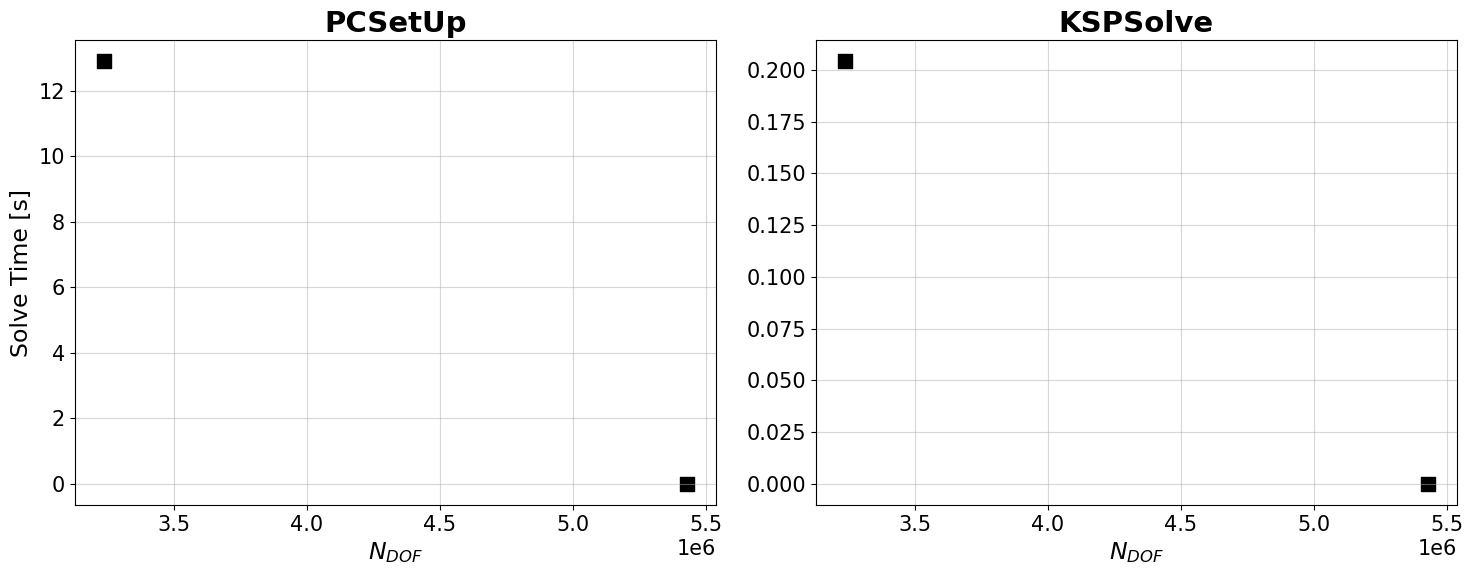

In [2]:
save_on = 0

Ndof_volume,_,T0_PCSetUp,T0_KSPSolve = read_Ndof_T0('perturb_stress/messages_sliplaw_debug*.log',print_on=True,p=6,D=2,fault=False,poisson=True)
fig,ax=plt.subplots(figsize=(8,6))

plt.tight_layout()
plt.show()